In [1]:
import numpy as np, matplotlib.pyplot as plt, glob, os, itertools, simplification.cutil as simpl, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, colorcet
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm

In [2]:
fnameP = 'Y:/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd/'
fnameP+= 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd/'
fnameA+= 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnames = [fnameP, fnameA]

In [3]:
RECORDING = '4-5-19-a'

fnameIdx = 0

# Find the cluster ID data
arrClustersAll = [np.load('\\\\?\\Z:\\behavior\\{}\\wavelet\\{}'.format(
    RECORDING, os.path.basename(fnames[fnameIdx]).replace('.npy', '.clusters.npy')))[:,0].astype(int) \
        for fnameIdx in range(len(fnames))]

# Load the position data
fnamePos = glob.glob('\\\\?\\Z:\\behavior\\{}\\croprot\\*_dlc_abs_filt_interp_mvmt_noborder.npy'.format(
    RECORDING))[0]

xy = np.mean(np.load(fnamePos)[:, [0,1], 0:2], axis=1)

In [4]:
def filterClusters(cl, clusterLabels, clusterLabelsUnique, minrun=12):
    runs = []
    for c in cl:
        if clusterLabels is not None and clusterLabelsUnique is not None:
            if len([k for k in clusterLabels if c in clusterLabels[k]]) == 0:
                c = -1
            else:
                a = [k for k in clusterLabels if c in clusterLabels[k]][0]
                if a in clusterLabelsUnique:
                    c = clusterLabelsUnique.index(a)
                else:
                    c = -1
        if len(runs) == 0:
            runs.append([c, ])
        elif runs[-1][-1] == c:
            runs[-1].append(c)
        else:
            runs.append([c, ])
    return np.hstack([np.array(x if len(x) >= minrun else [np.nan, ] * len(x), dtype=np.float64) for x in runs])

In [5]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

In [6]:
fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
fnamesLabels = (fnameClusterLabelsP, fnameClusterLabelsA)

clusterLabels = (loadLabels(fnamesLabels[0]), loadLabels(fnamesLabels[1]))
clusterLabelsUnique = list(set(list(clusterLabels[0].keys()) + list(clusterLabels[1].keys())))
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in \
    ['noisy', 'stationary-anterior', 'stationary-posterior', 'stationary']]

In [7]:
COLORS_CLUSTERS = {
 'walk': '#0066b5',
 'one-leg-after-other': '#215440',
 'extrude-slow': '#f0e442',
 'extrude': '#009e73',
 'left-leg': '#e69f00',
 'both-legs': '#61133e',
 'stationary': '#000000',
 'stationary-posterior': '#666666',
 'stationary-anterior': '#666666',
 'stabilimentum': '#cc79a7',
 'noisy': None,
 'right-leg': '#6dc5f7',
 'bend-abdomen': '#d55e00'
}

COLORS_CLUSTERS = {x:(y+'cc' if y is not None else None) for x, y in COLORS_CLUSTERS.items()}

In [8]:
def formatLabel(x):
    return x.replace('-', ' ')

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


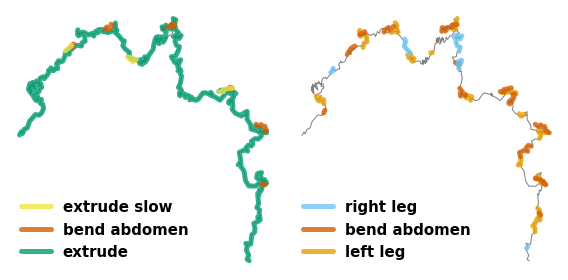

In [9]:
i0 = 545000
dur = 4500
resVW = 2

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
for k in range(2):
    cls = filterClusters(arrClustersAll[k][i0:(i0+dur)], clusterLabels[k], clusterLabelsUnique, 12)

    clsUnique = np.unique(cls[cls >= 0]).astype(int)
    clsUniqueCount = [np.sum(cls == x) for x in clsUnique]
    
    _xySimpl = xy[i0:(i0+dur), :].copy()
    _xySimpl = simpl.simplify_coords_vw(_xySimpl, resVW)
    ax[k].plot(_xySimpl[:, 0], _xySimpl[:, 1], 
        linewidth=1, zorder=-10000, color='gray')

    for cli, cl in enumerate(clsUnique):
        _xy = xy[i0:(i0+dur), :].copy()
        _xy = _xy[cls == cl,:]
        segmentIDs = np.cumsum(np.linalg.norm(_xy - np.roll(_xy, 1, axis=0), axis=1) > 10)
        for _sid, sid in enumerate(np.unique(segmentIDs)):
            _xySimpl = _xy[segmentIDs==sid, :].copy()
            _xySimpl = simpl.simplify_coords_vw(_xySimpl, resVW)
            ax[k].plot(_xySimpl[:, 0], _xySimpl[:, 1], 
                       color=COLORS_CLUSTERS[clusterLabelsUnique[cl]], linewidth=5, 
                       zorder=-clsUniqueCount[cli], 
                       label=formatLabel(clusterLabelsUnique[cl]) if _sid == 0 else None, 
                       solid_capstyle='round')
    ax[k].set_axis_off()
    
    ax[k].legend(frameon=False, fontsize=15)
    
# Finalize figure
fig.tight_layout()

# Output
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_4a.pdf', dpi=600)